<a href="https://colab.research.google.com/github/juhumkwon/source_code/blob/main/a_11__vae.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Epoch 1/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 90s 186ms/step - loss: 0.3503 - val_loss: 0.2636
Epoch 2/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 87s 186ms/step - loss: 0.2635 - val_loss: 0.2629
Epoch 3/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 142s 186ms/step - loss: 0.2631 - val_loss: 0.2628
Epoch 4/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 140s 181ms/step - loss: 0.2635 - val_loss: 0.2628
Epoch 5/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 142s 182ms/step - loss: 0.2632 - val_loss: 0.2628
Epoch 6/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 142s 183ms/step - loss: 0.2631 - val_loss: 0.2629
Epoch 7/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 142s 184ms/step - loss: 0.2632 - val_loss: 0.2626
Epoch 8/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 142s 184ms/step - loss: 0.2632 - val_loss: 0.2626
Epoch 9/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 142s 185ms/step - loss: 0.2633 - val_loss: 0.2627
Epoch 10/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 86s 183ms/step - loss: 0.2633 - val_loss: 0.2627
Epoch 11/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 85s 182ms/step - loss: 0.2629 - val_loss: 0.2628
Epoch 12/50


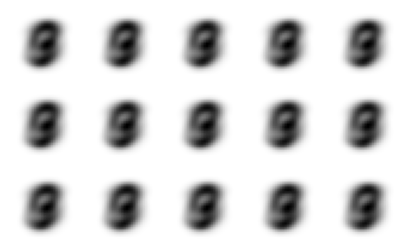

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers
import numpy as np
import matplotlib.pyplot as plt

# MNIST 데이터셋 로드
(x_train, _), (x_valid, _) = tf.keras.datasets.mnist.load_data()
x_train = x_train.astype("float32") / 255.0
x_valid = x_valid.astype("float32") / 255.0
x_train = np.reshape(x_train, (-1, 28, 28, 1))
x_valid = np.reshape(x_valid, (-1, 28, 28, 1))

# 하이퍼파라미터
latent_dim = 2  # 잠재 공간의 차원

# 인코더 정의
def build_encoder():
    encoder_inputs = tf.keras.Input(shape=(28, 28, 1))
    x = layers.Conv2D(32, 3, activation="relu", strides=2, padding="same")(encoder_inputs)
    x = layers.Conv2D(64, 3, activation="relu", strides=2, padding="same")(x)
    x = layers.Flatten()(x)
    x = layers.Dense(16, activation="relu")(x)
    z_mean = layers.Dense(latent_dim, name="z_mean")(x)
    z_log_var = layers.Dense(latent_dim, name="z_log_var")(x)
    return tf.keras.Model(encoder_inputs, [z_mean, z_log_var], name="encoder")

# 샘플링 레이어 정의
class Sampling(layers.Layer):
    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

# 디코더 정의
def build_decoder():
    decoder_inputs = tf.keras.Input(shape=(latent_dim,))
    x = layers.Dense(7 * 7 * 64, activation="relu")(decoder_inputs)
    x = layers.Reshape((7, 7, 64))(x)
    x = layers.Conv2DTranspose(64, 3, activation="relu", strides=2, padding="same")(x)
    x = layers.Conv2DTranspose(32, 3, activation="relu", strides=2, padding="same")(x)
    decoder_outputs = layers.Conv2DTranspose(1, 3, activation="sigmoid", padding="same")(x)
    return tf.keras.Model(decoder_inputs, decoder_outputs, name="decoder")

# VAE 모델 정의
class VAE(tf.keras.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super(VAE, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.sampling = Sampling()

    def call(self, inputs):
        z_mean, z_log_var = self.encoder(inputs)
        z = self.sampling([z_mean, z_log_var])
        reconstructed = self.decoder(z)
        kl_loss = -0.5 * tf.reduce_mean(1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))
        self.add_loss(kl_loss)
        return reconstructed

# 인코더와 디코더 생성
encoder = build_encoder()
decoder = build_decoder()

# VAE 모델 인스턴스 생성
vae = VAE(encoder, decoder)

# 모델 컴파일 및 학습
vae.compile(optimizer="adam", loss="binary_crossentropy")
history = vae.fit(x_train, x_train, epochs=50, batch_size=128,
                             validation_data=(x_valid, x_valid))

# 이미지 생성 및 시각화
def plot_images(images, n_rows, n_cols):
    plt.figure(figsize=(n_cols, n_rows))
    for i in range(n_rows * n_cols):
        plt.subplot(n_rows, n_cols, i + 1)
        plt.imshow(images[i], cmap="binary")
        plt.axis("off")
    plt.show()


# 새로운 코딩 생성 및 이미지 복원
n_images = 15  # 생성할 이미지 수
codings = tf.random.normal(shape=[n_images, latent_dim])  # 잠재 공간에서 무작위로 샘플링
# Use the decoder instance from the VAE model
generated_images = vae.decoder(codings).numpy()

# 이미지 출력
plot_images(generated_images, n_rows=3, n_cols=5)  # 3행 5열의 이미지 출력
